In this project we are working on a dataset from tweeter users’ tweets on hashtags related to the 2015 Super Bowl. We are given 6 json files containing tweets with specific hashtag. Each json file is related to one hashtag from the hashtag list {nfl, gopatriots, patriots, sb49, superbowl, gohawks}. 
In part one of this project, we first perform feature extraction to read and chose appropriate features for our prediction purposes, and then we construct the training sets. Afterwards, we train a couple of regression models on the dataset to predict the popularity of a hashtag from its current and previous popularity trends.  
In part two, we predict the location of the tweets’ authors from the textual information of their tweets. We formulate this problem as a classification problem and build a training set with binary labels, either Washington state or Massachusetts state.


## Part 1: Popularity Prediction

In [66]:
import re
import json
import datetime
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [67]:
# function to read the json strings to dataframe
def read_text_files(hashtag, return_day_count = False, return_hour_count = False):
    path = "path"
    with open(path+hashtag+'.txt', 'r',encoding="utf8") as f:
        retweet_count,month,day,hour,followers,place,title,time = [],[],[],[],[],[],[],[]
        url, mentions, rank, hashtags = [], [], [], []
        pst_tz = pytz.timezone('US/Pacific') 
        for line in f:
            tweet = json.loads(line)
            retweet_count.append(tweet['metrics']['citations']['total']) 
            month.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz).month)
            day.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz).day)
            hour.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz).hour)
            followers.append(tweet['author']['followers'])
            time.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz))
            place.append(tweet['tweet']['user']['location'])
            title.append(tweet['title'])
            
            url.append(len(tweet['tweet']['entities']['urls']))#Q4 feature
            mentions.append(len(tweet['tweet']['entities']['user_mentions']))#Q4 feature
            rank.append(tweet['metrics']['ranking_score'])#Q4 feature
            hashtags.append(tweet['title'].count('#'))#Q4 feature
            
        
    dic = {'retweet_count':retweet_count,'month':month,'day':day,'hour':hour,
           'followers':followers,'time':time,'place':place,'title':title, 
           'url': url, 'mention':mentions, 'rank': rank, 'hashtag': hashtags}
    
    df = pd.DataFrame(dic, columns=['month', "day", "hour", "followers",'retweet_count',
                                    "time", "place", "title","url", "mention", 'rank','hashtag'])
    day_count = np.array(month)*31 + np.array(day) - 44 # total time in days
    hour_count = (day_count-1)*24 + np.array(hour) # total time in hours
    if return_day_count:
        df['day_count'] = day_count
    if return_hour_count:
        df['hour_count'] = hour_count
    return df  

In [68]:
from os import listdir
from os.path import isfile, join

hashtag_list = []
avg_tts_p_hr = []
avg_followers = []
avg_rett = []

mypath = "path"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for file in onlyfiles:
    hashtag = file[:-4]
    print (hashtag)
    df = read_text_files(hashtag, return_day_count = True, return_hour_count = True)
    
    hashtag_list.append(hashtag)
    avg_tts_p_hr.append(df.groupby(['month','day','hour']).agg(["count"]).mean()[0])
    avg_followers.append (np.mean(df['followers']))
    avg_rett.append (np.mean(df['retweet_count']))

Q1_dic = {"hashtag": hashtag_list,
                     "avg_tts_p_hr": avg_tts_p_hr,
                     "avg_followers": avg_followers,
                     "avg_rett": avg_rett}
Q1_df = pd.DataFrame (data = Q1_dic)

tweets_#nfl
tweets_#gopatriots
tweets_#patriots
tweets_#sb49
tweets_#superbowl
tweets_#gohawks


In [13]:
print (Q1_df)

              hashtag  avg_tts_p_hr  avg_followers  avg_rett
0         tweets_#nfl    399.694683    4662.375445  1.534460
1  tweets_#gopatriots     53.312925    1427.252605  1.408192
2    tweets_#patriots    750.632027    3280.463562  1.785287
3        tweets_#sb49   1384.821229   10374.160292  2.527134
4   tweets_#superbowl   2067.824532    8814.967994  2.391190
5     tweets_#gohawks    296.705263    2217.923736  2.013209


In [64]:
Q1_df.to_csv("Q1_answers.csv")

#### number of tweets in hour over time for #SuperBowl and #NFL

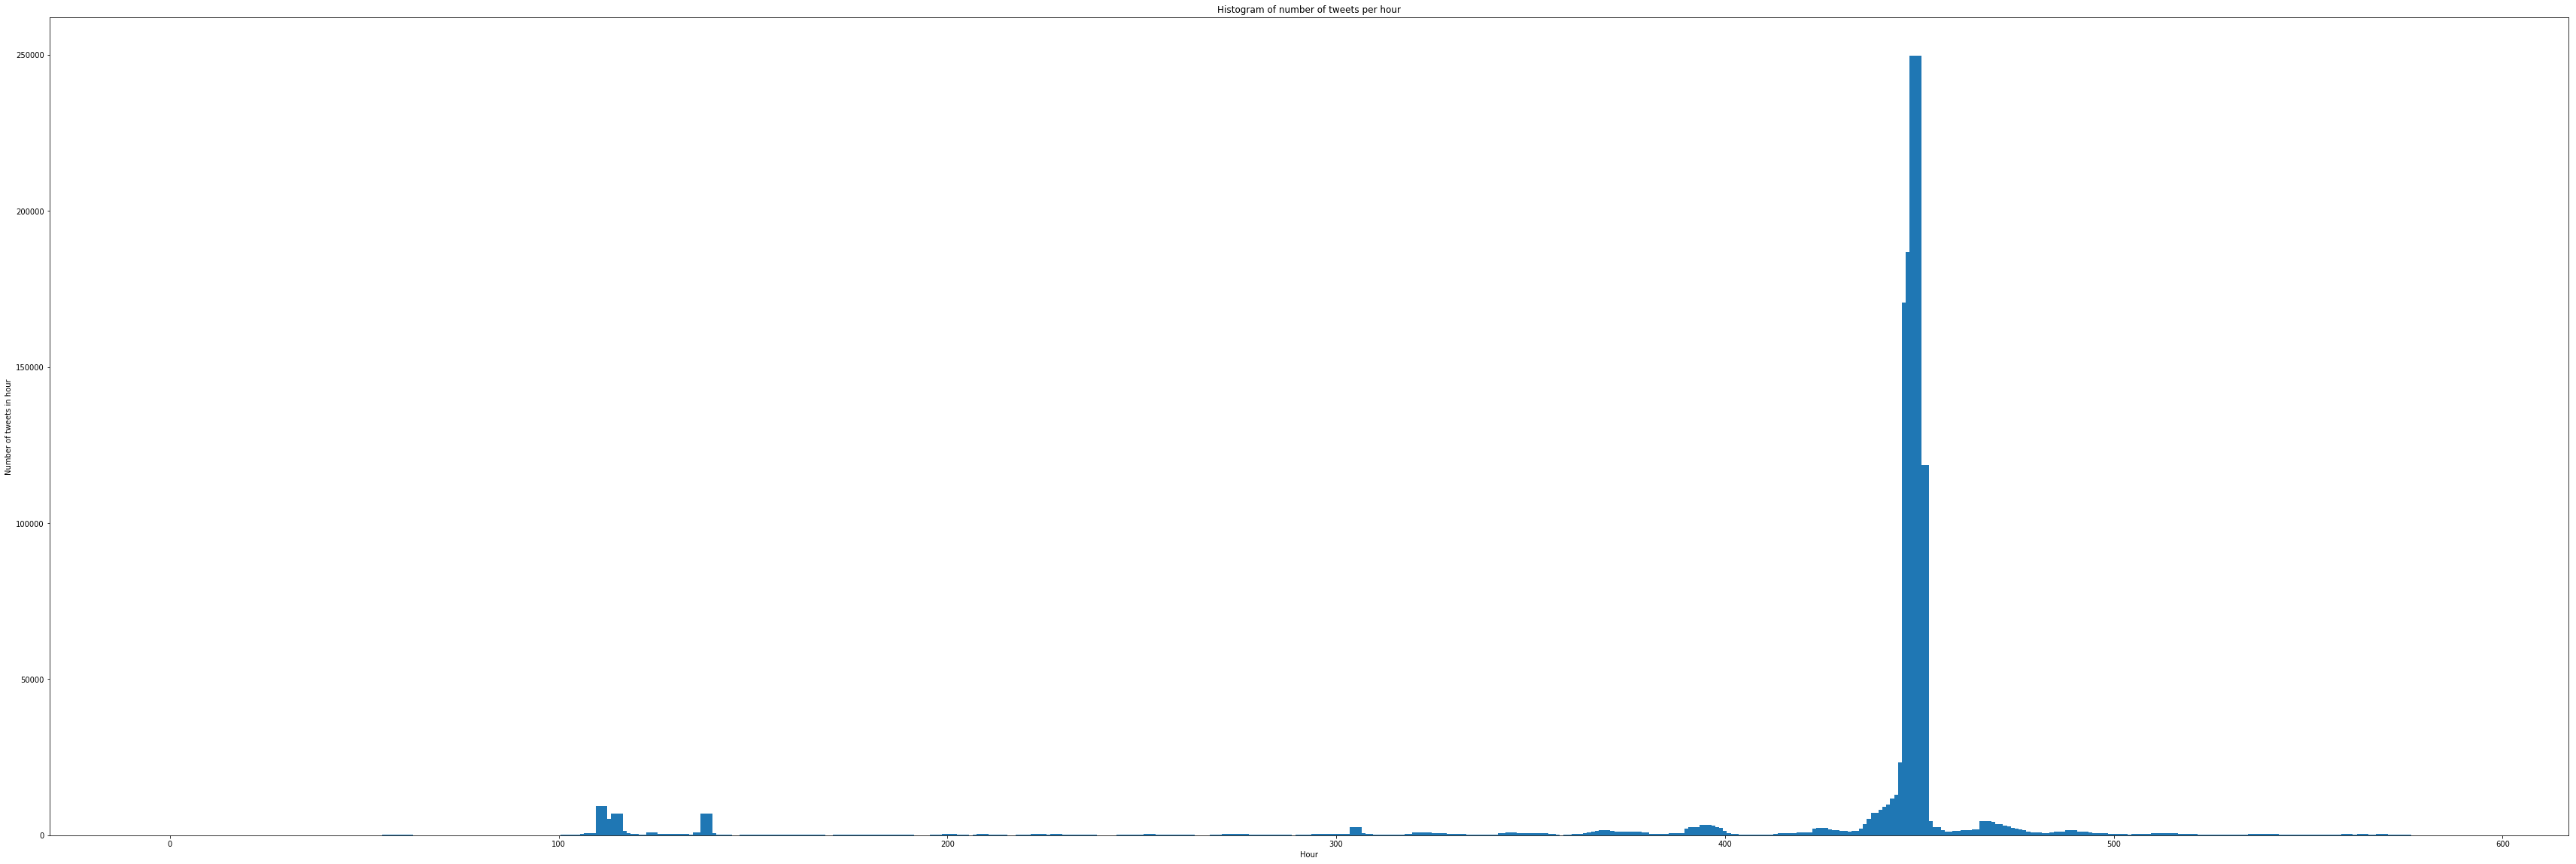

In [56]:
hashtag = "tweets_#superbowl"
df_SuperBowl = read_text_files(hashtag, return_day_count = True, return_hour_count = True)
num_of_tweets = df_SuperBowl.groupby(['month','day','hour']).agg(["count"])["followers"]
num_of_tweets = num_of_tweets.loc[:,"count"].values
fig = plt.figure(figsize=(60, 20))
plt.bar(range(len(num_of_tweets)),num_of_tweets,width=3,log = False)
plt.xlabel('Hour')
plt.ylabel('Number of tweets in hour')
plt.title('Histogram of number of tweets per hour')
plt.show()

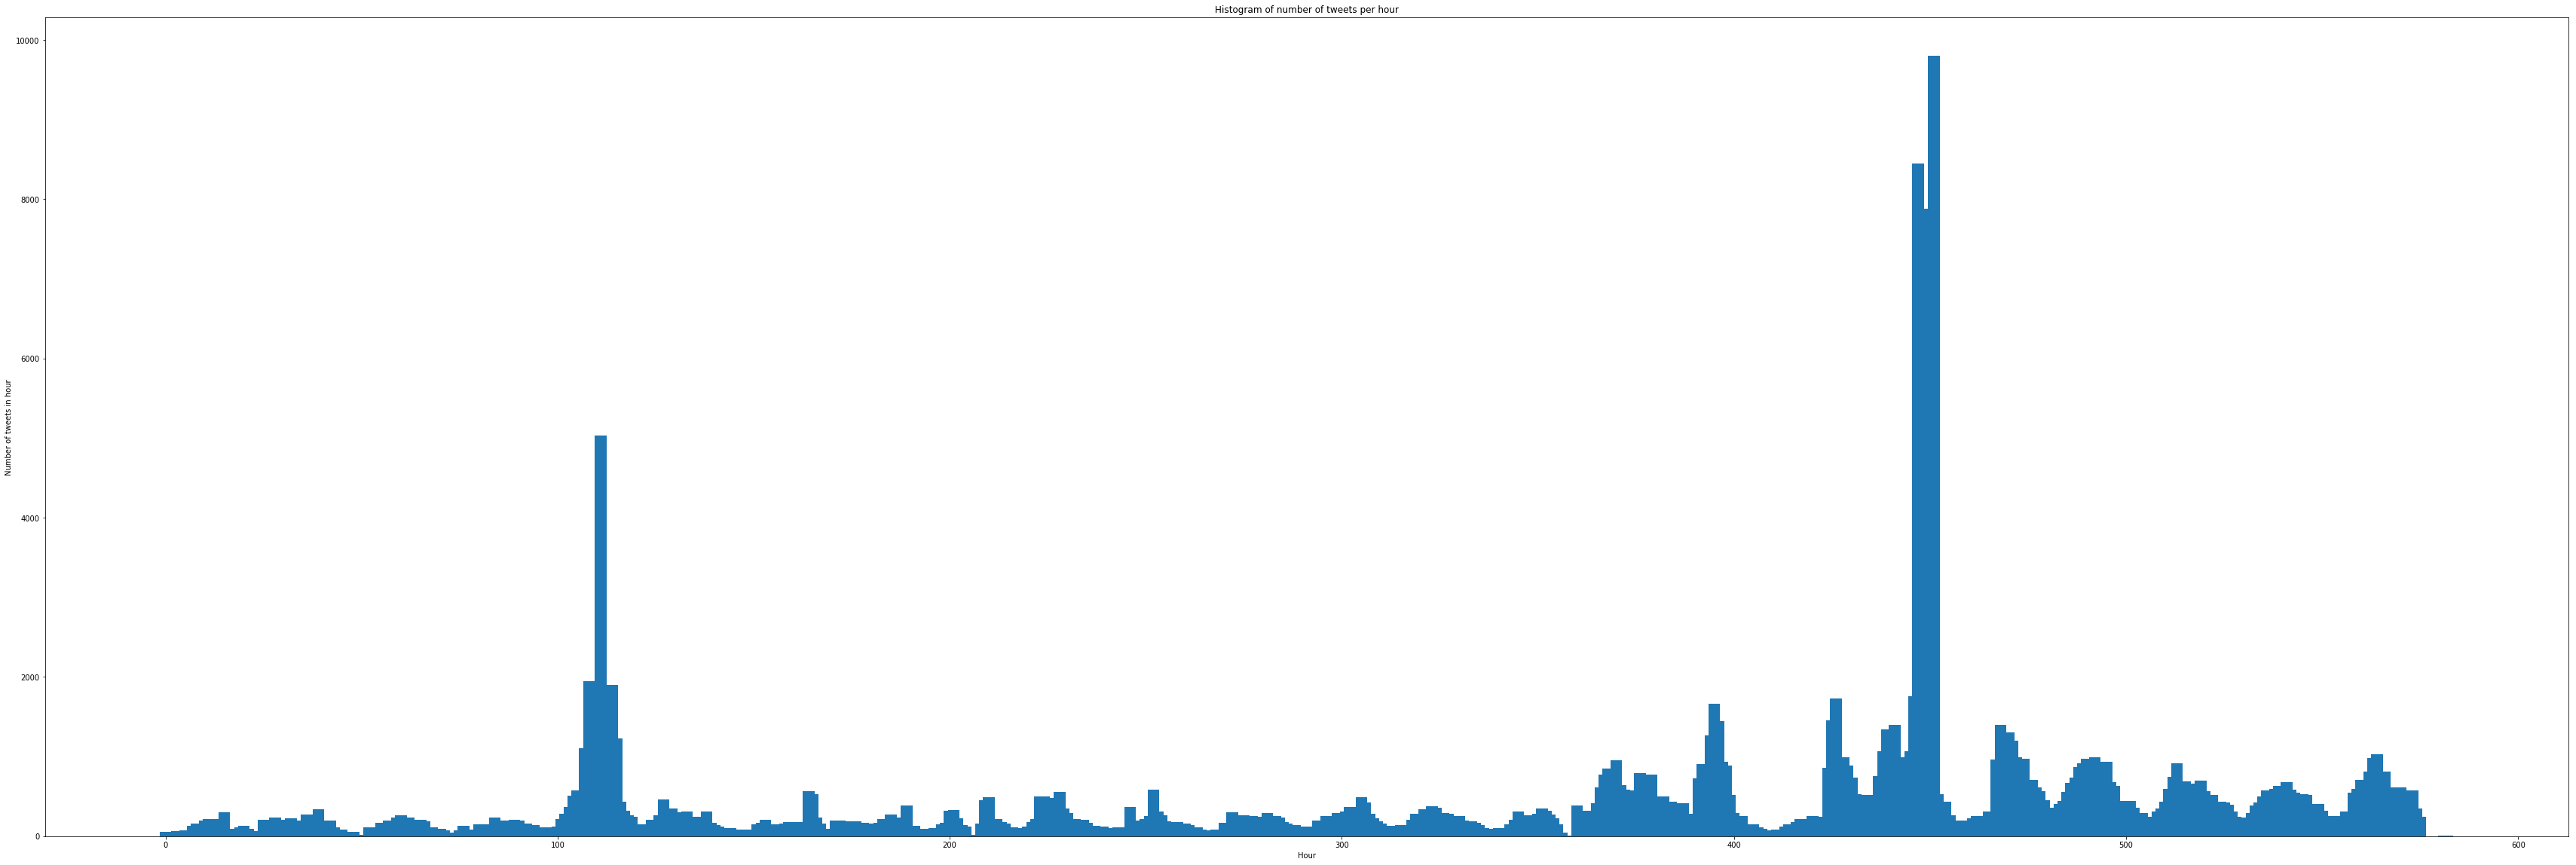

In [57]:
hashtag = "tweets_#nfl"
df_nfl = read_text_files(hashtag, return_day_count = True, return_hour_count = True)
num_of_tweets = df_nfl.groupby(['month','day','hour']).agg(["count"])["followers"]
num_of_tweets = num_of_tweets.loc[:,"count"].values
fig = plt.figure(figsize=(60, 20))
plt.bar(range(len(num_of_tweets)),num_of_tweets,width=3,log = False)
plt.xlabel('Hour')
plt.ylabel('Number of tweets in hour')
plt.title('Histogram of number of tweets per hour')
plt.show()

From Figure 2 and Error! Reference source not found. we can observe that there were two surges of tweets for these two hashtags, one around hour 110 and another big one around hour 450. Our guess is that there were some important events or matches going on at these times. For example, the latter could be related to the game itself. 

#### Linear regression

In [50]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
from os import listdir
from os.path import isfile, join

In [51]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std


def regression_model_feature_extraction (hashtag):
    # bulding the features and the labels
    df = read_text_files(hashtag, return_day_count = True, return_hour_count = True)
    reg_model_df = df.groupby(["hour_count"]).agg(["count"])["followers"]
    reg_model_df.rename(index=str, columns={"count": "num_of_tweets"},inplace=True)
    df_1 = df.loc[:,["hour_count","retweet_count"]]
    reg_model_df['retweet_sum'] = df_1.groupby(["hour_count"]).agg(["sum"])["retweet_count"].loc[:,"sum"].values
    df_1 = df.loc[:,["hour_count","followers"]]
    reg_model_df['followers_sum'] = df_1.groupby(["hour_count"]).agg(["sum"])["followers"].loc[:,"sum"].values
    df_1 = df.loc[:,["hour_count","followers"]]
    reg_model_df['followers_max'] = df_1.groupby(["hour_count"]).agg(["max"])["followers"].loc[:,"max"].values
    df_1 = df.loc[:,["hour_count","hour"]]
    reg_model_df["hour"] = df_1.groupby(["hour_count"]).agg(["max"])["hour"].loc[:,"max"].values
    reg_model_df["y"] = np.roll (reg_model_df["num_of_tweets"].values,-1)
    
    return reg_model_df

In [ ]:
def plot_top3_features(file, df, output_predicted):
    features = top3_features[file]
    opt = []
    for i in range(3):
        cur_feature = []
        for index in df.index:
            cur_feature.append(df.loc[index, features[i]:features[i]].values)
        cur_feature.pop()
        opt.append(cur_feature)
    
    fig = plt.figure(figsize=(16,5))
    fig.suptitle(file, y=1.07, fontsize=23)
    for i in range(3):
        ax = plt.subplot(131+i)
        ax.set_title('Predictant vs '+features[i], fontsize=18)
        ax.scatter(opt[i], output_predicted, color='deeppink', edgecolors='k')
        ax.set_xlabel(features[i], fontsize=14)
        ax.set_ylabel('predicted number of tweets', fontsize=14)
    plt.tight_layout()
    plt.show()
    print ('==========================================================================================================')

In [52]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for file in onlyfiles:
    hashtag = file[:-4]
    print ("########################",hashtag,"########################")
    reg_model_df = regression_model_feature_extraction (hashtag)
    features = ["num_of_tweets",'retweet_sum','followers_sum','followers_max',"hour"]
    X = reg_model_df [features].values
    y = reg_model_df [["y"]].values

    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    y_pred = results.predict(X)
    print ("Root mean square error:",np.sqrt(mean_squared_error(y, y_pred)))
    print(results.summary())


######################## tweets_#nfl ########################
Root mean square error: 520.817552709155
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 17 Mar 2019   Prob (F-statistic):          2.17e-103
Time:                        13:43:13   Log-Likelihood:                -4474.1
No. Observations:                 583   AIC:                             8960.
Df Residuals:                     577   BIC:                             8986.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Root mean square error: 7238.38760880722
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     464.4
Date:                Sun, 17 Mar 2019   Prob (F-statistic):          2.99e-200
Time:                        13:45:16   Log-Likelihood:                -6049.7
No. Observations:                 587   AIC:                         1.211e+04
Df Residuals:                     581   BIC:                         1.214e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

#### Adding new features 

In [71]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std


def regression_model_feature_extraction_Q4 (hashtag):
    # bulding the features and the labels
    df = read_text_files(hashtag, return_day_count = True, return_hour_count = True)
    reg_model_df = df.groupby(["hour_count"]).agg(["count"])["followers"]
    reg_model_df.rename(index=str, columns={"count": "num_of_tweets"},inplace=True)
    df_1 = df.loc[:,["hour_count","retweet_count"]]
    reg_model_df['retweet_sum'] = df_1.groupby(["hour_count"]).agg(["sum"])["retweet_count"].loc[:,"sum"].values
    df_1 = df.loc[:,["hour_count","followers"]]
    reg_model_df['followers_sum'] = df_1.groupby(["hour_count"]).agg(["sum"])["followers"].loc[:,"sum"].values
    df_1 = df.loc[:,["hour_count","followers"]]
    reg_model_df['followers_max'] = df_1.groupby(["hour_count"]).agg(["max"])["followers"].loc[:,"max"].values
    df_1 = df.loc[:,["hour_count","hour"]]
    reg_model_df["hour"] = df_1.groupby(["hour_count"]).agg(["max"])["hour"].loc[:,"max"].values
    reg_model_df["y"] = np.roll (reg_model_df["num_of_tweets"].values,-1)
    # 'url': url, 'mention':mentions, 'rank': rank, 'hashtag': hashtags}
    df_1 = df.loc[:,["hour_count","url"]]
    reg_model_df["url"] = df_1.groupby(["hour_count"]).agg(["sum"])["url"].loc[:,"sum"].values
    df_1 = df.loc[:,["hour_count",'mention']]
    reg_model_df['mention'] = df_1.groupby(["hour_count"]).agg(["sum"])['mention'].loc[:,"sum"].values
    df_1 = df.loc[:,["hour_count","rank"]]
    reg_model_df["rank"] = df_1.groupby(["hour_count"]).agg(["sum"])["rank"].loc[:,"sum"].values
    df_1 = df.loc[:,["hour_count","hashtag"]]
    reg_model_df["hashtag"] = df_1.groupby(["hour_count"]).agg(["sum"])["hashtag"].loc[:,"sum"].values
    
    
    return reg_model_df

######################## tweets_#nfl ########################
Root mean square error: 448.55518526066146
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     136.1
Date:                Sun, 17 Mar 2019   Prob (F-statistic):          4.56e-136
Time:                        22:33:33   Log-Likelihood:                -4387.1
No. Observations:                 583   AIC:                             8794.
Df Residuals:                     573   BIC:                             8838.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

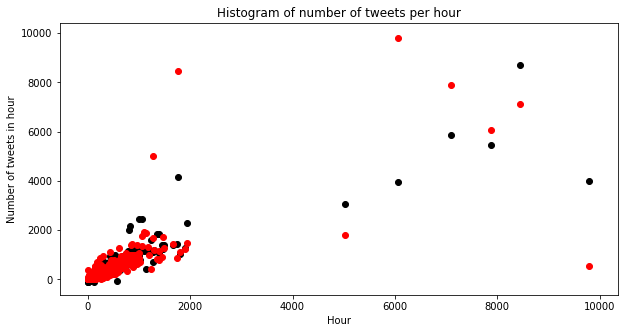

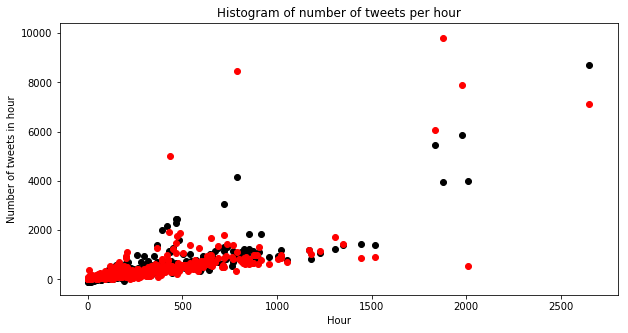

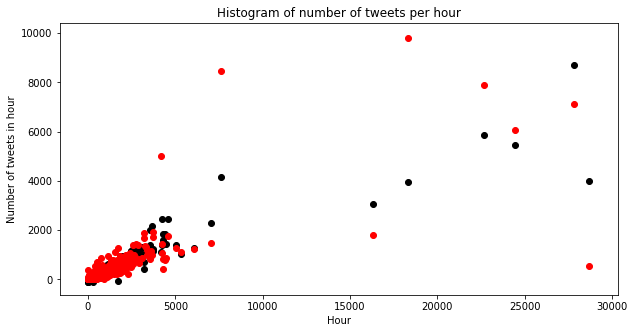

######################## tweets_#gopatriots ########################
Root mean square error: 116.05378703348852
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     294.2
Date:                Sun, 17 Mar 2019   Prob (F-statistic):          7.32e-178
Time:                        22:33:35   Log-Likelihood:                -2722.3
No. Observations:                 441   AIC:                             5465.
Df Residuals:                     431   BIC:                             5505.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

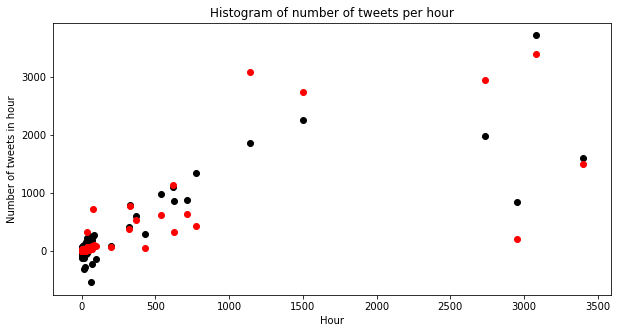

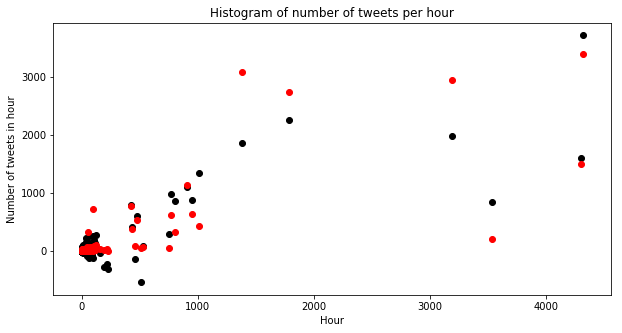

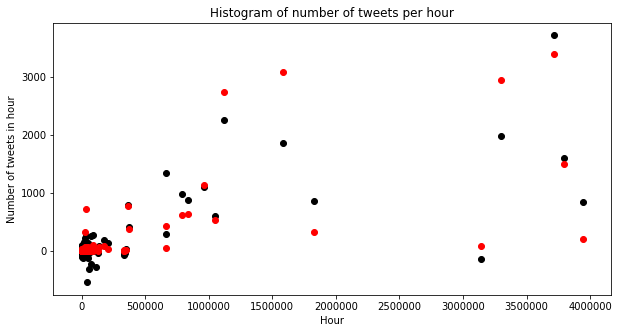

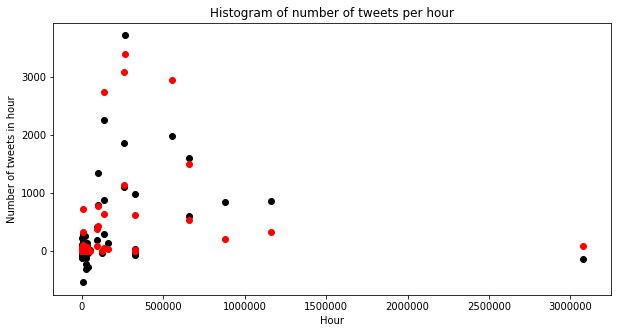

######################## tweets_#patriots ########################
Root mean square error: 1710.1549738889635
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     277.8
Date:                Sun, 17 Mar 2019   Prob (F-statistic):          3.11e-203
Time:                        22:33:58   Log-Likelihood:                -5202.7
No. Observations:                 587   AIC:                         1.043e+04
Df Residuals:                     577   BIC:                         1.047e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

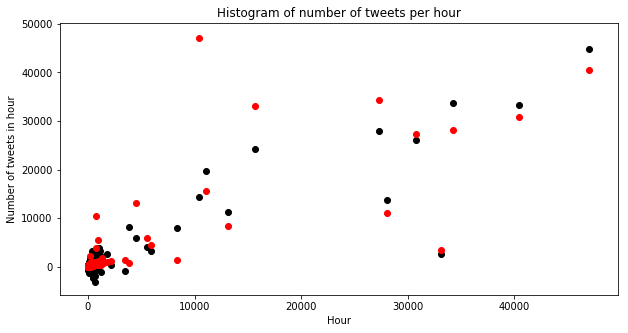

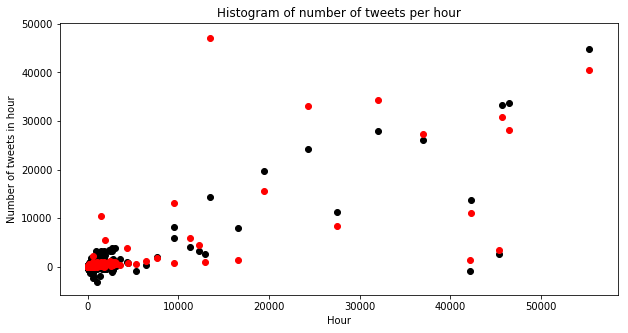

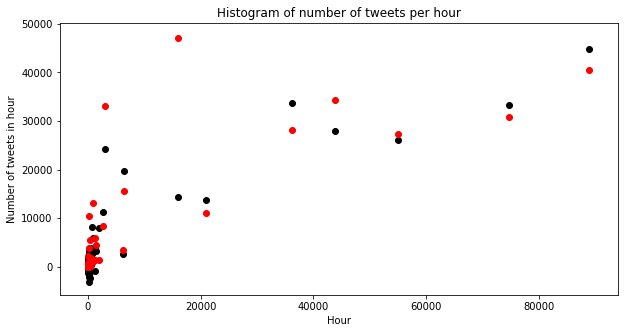

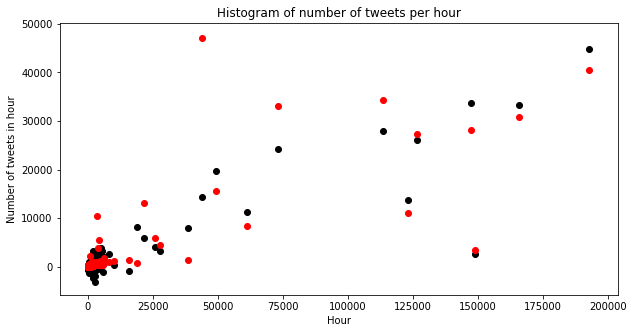

######################## tweets_#sb49 ########################
Root mean square error: 3727.153744655329
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     319.3
Date:                Sun, 17 Mar 2019   Prob (F-statistic):          6.31e-207
Time:                        22:34:37   Log-Likelihood:                -5177.9
No. Observations:                 537   AIC:                         1.038e+04
Df Residuals:                     527   BIC:                         1.042e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

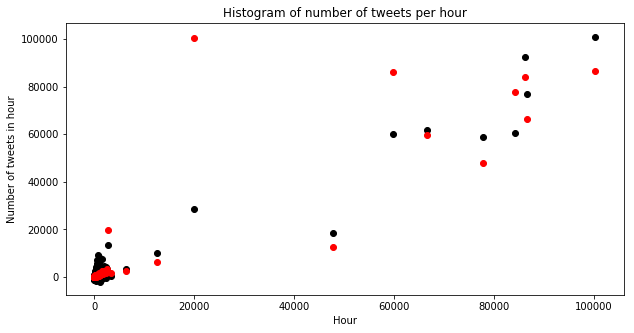

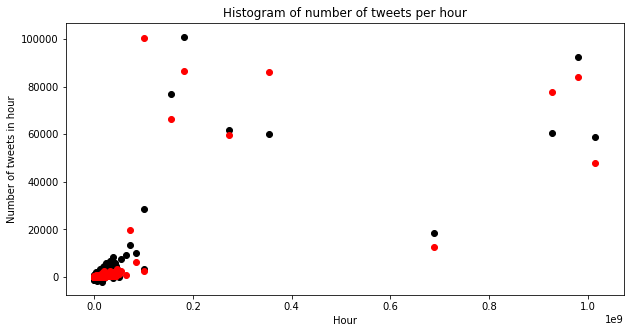

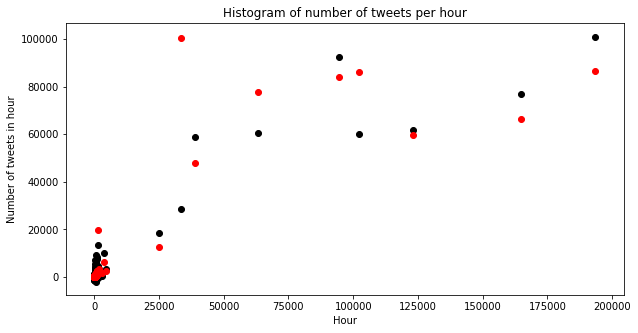

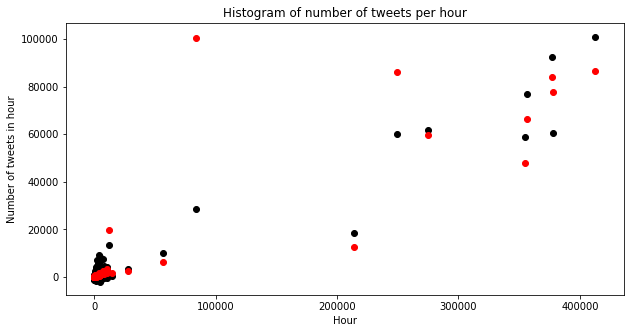

######################## tweets_#superbowl ########################
Root mean square error: 5550.873903160881
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     480.6
Date:                Sun, 17 Mar 2019   Prob (F-statistic):          1.97e-261
Time:                        22:35:41   Log-Likelihood:                -5893.9
No. Observations:                 587   AIC:                         1.181e+04
Df Residuals:                     577   BIC:                         1.185e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

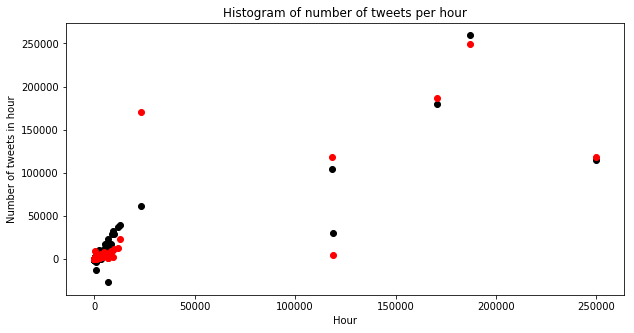

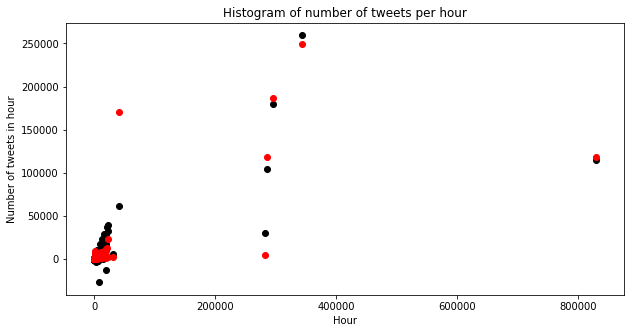

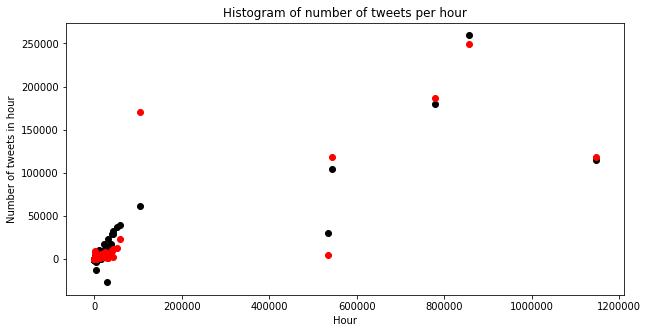

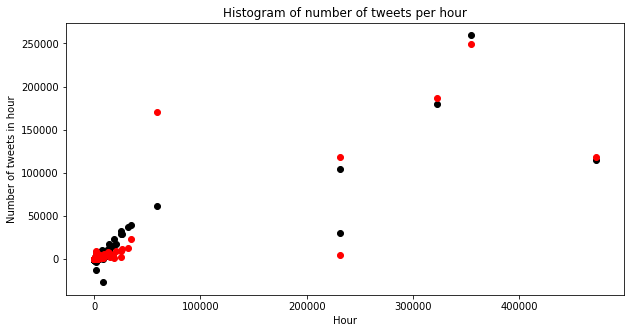

######################## tweets_#gohawks ########################
Root mean square error: 730.3072650570117
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     109.0
Date:                Sun, 17 Mar 2019   Prob (F-statistic):          5.09e-117
Time:                        22:35:50   Log-Likelihood:                -4567.1
No. Observations:                 570   AIC:                             9154.
Df Residuals:                     560   BIC:                             9198.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

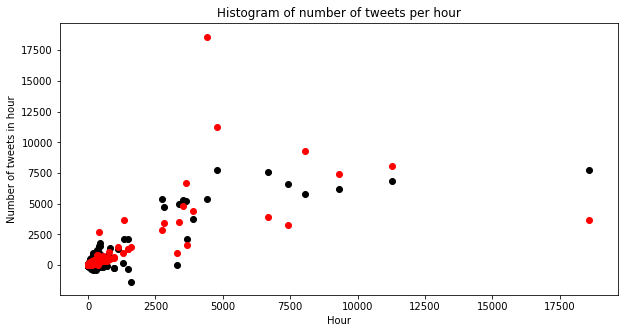

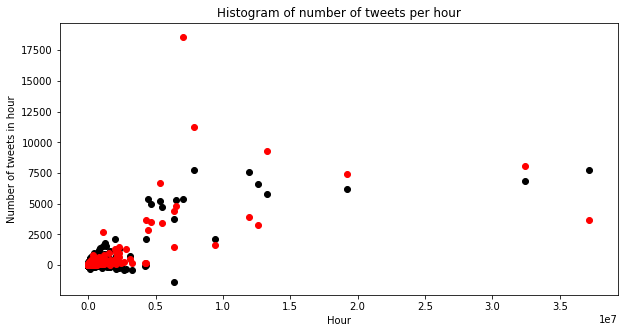

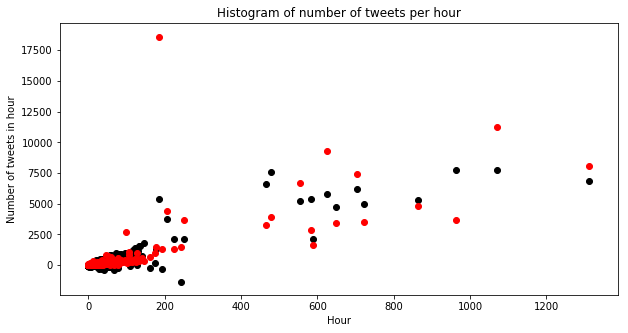

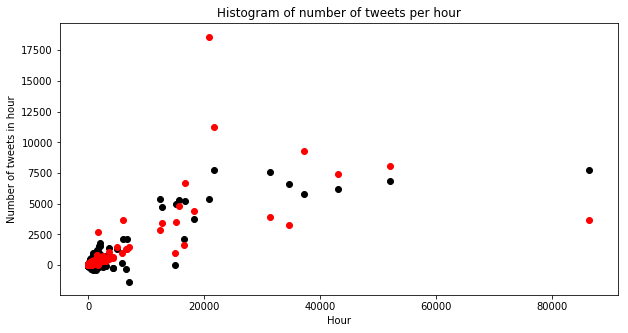

In [104]:
hashtag_best_features_list= {
'tweets_#gohawks':    ["num_of_tweets",'followers_sum',"url","rank"],
'tweets_#superbowl':  ["num_of_tweets",'retweet_sum',"rank","hashtag"],
'tweets_#sb49': ["num_of_tweets",'followers_sum',"mention","rank"],
'tweets_#patriots': ["num_of_tweets",'retweet_sum', "mention","rank"],
'tweets_#gopatriots': ["num_of_tweets",'retweet_sum','followers_sum','followers_max'],
'tweets_#nfl': ["num_of_tweets", "url", "hashtag"]}
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for file in onlyfiles:
    hashtag = file[:-4]
    print ("########################",hashtag,"########################")
    reg_model_df = regression_model_feature_extraction_Q4 (hashtag)
    features = ["num_of_tweets",'retweet_sum','followers_sum','followers_max',"hour",
               "url","mention","rank","hashtag"]
    X = reg_model_df [features].values
    y = reg_model_df [["y"]].values

    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    y_pred = results.predict(X)
    print ("Root mean square error:",np.sqrt(mean_squared_error(y, y_pred)))
    print(results.summary())
    
    for feature in hashtag_best_features_list[hashtag]:
        fig = plt.figure(figsize=(10, 5))
        x = reg_model_df [feature].values
        plt.scatter(x,y_pred, color='black')
        plt.scatter(x,y, color = 'red')
        plt.xlabel('Hour')
        plt.ylabel('Number of tweets in hour')
        plt.title('Histogram of number of tweets per hour')
    plt.show()
        

In [96]:
hashtag_best_features_list= {
'#tweets_#gohawks':    ["num_of_tweets",'followers_sum',"url","rank"],
'#tweets_#superbowl':  ["num_of_tweets",'retweet_sum',"rank","hashtag"],
'#tweets_#sb49': ["num_of_tweets",'followers_sum',"mention","rank"],
'#tweets_#patriots': ["num_of_tweets",'retweet_sum', "mention","rank"],
'#tweets_#gopatriots': ["num_of_tweets",'retweet_sum','followers_sum','followers_max'],
'#tweets_#nfl': ["num_of_tweets", "url", "hashtag"]}
print (hashtag_best_features_list['#tweets_#gohawks'])

['num_of_tweets', 'followers_sum', 'url', 'rank']


In [ ]:
hashtag_best_features_list= {
'#tweets_#gohawks':    ["num_of_tweets",'followers_sum',"url","rank"],
'#tweets_#superbowl':  ["num_of_tweets",'retweet_sum',"rank","hashtag"],
'#tweets_#sb49': ["num_of_tweets",'followers_sum',"mention","rank","hashtag"],
'#tweets_#patriots': ["num_of_tweets",'retweet_sum', "mention","rank","hashtag"],
'#tweets_#gopatriots': ["num_of_tweets",'retweet_sum','followers_sum','followers_max', "url","mention","rank","hashtag"],
'#tweets_#nfl': ["num_of_tweets", "url", "hashtag"]}
    
num_of_tweets = df_nfl.groupby(['month','day','hour']).agg(["count"])["followers"]
num_of_tweets = num_of_tweets.loc[:,"count"].values
fig = plt.figure(figsize=(60, 20))
plt.bar(range(len(num_of_tweets)),num_of_tweets,width=3,log = False)
plt.xlabel('Hour')
plt.ylabel('Number of tweets in hour')
plt.title('Histogram of number of tweets per hour')
plt.show()

In [5]:
def regression_model_ (hashtag):
    # bulding the features and the labels
    df = read_text_files(hashtag, return_day_count = True, return_hour_count = True)
    reg_model_df = df.groupby(["hour_count"]).agg(["count"])["followers"]
    reg_model_df.rename(index=str, columns={"count": "num_of_tweets"},inplace=True)
    reg_model_df['retweet_sum'] = df.groupby(["hour_count"]).agg(["sum"])["retweet_count"].loc[:,"sum"].values
    reg_model_df['followers_sum'] = df.groupby(["hour_count"]).agg(["sum"])["followers"].loc[:,"sum"].values
    reg_model_df['followers_max'] = df.groupby(["hour_count"]).agg(["max"])["followers"].loc[:,"max"].values
    reg_model_df["hour"] = df.groupby(["hour_count"]).agg(["max"])["hour"].loc[:,"max"].values
    reg_model_df["y"] = np.roll (reg_model_df["num_of_tweets"].values,-1)
    
    #building the linear regression model
    features = ["num_of_tweets",'retweet_sum','followers_sum','followers_max',"hour"]
    X = reg_model_df [features].values
    y = reg_model_df [["y"]].values
    lin_m = linear_model.LinearRegression(fit_intercept=False,normalize=True)
    lin_m.fit(X,y)
    y_pred = lin_m.predict(X)

    #calculating model performance metrics
    pmetric_MSE = mean_squared_error(y, y_pred)
    pmetric_RSM = r2_score(y, y_pred)  
    
    #calculating feature significance
    params = np.append(lin_m.intercept_,lin_m.coef_)
    predictions = y_pred
    x = X

    newX = np.append(np.ones((len(x),1)), x, axis=1)
    MSE = np.sqrt((sum((y-predictions)**2))/(len(newX)-len(newX[0])))


    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)
    
    features_ = ["constant","num_of_tweets",'retweet_sum','followers_sum','followers_max',"hour"]

    feature_sig = pd.DataFrame()
    
    feature_sig["Feature"], feature_sig["t values"], feature_sig["Probabilites"] = [features_,ts_b,p_values]
    
    return pmetric_MSE, pmetric_RSM, feature_sig



In [6]:
hashtag = "tweets_#nfl"
pmetric_MSE, pmetric_RSM, feature_sig = regression_model (hashtag)
print (pmetric_MSE, pmetric_RSM)
print (feature_sig)

275246.06818161067 0.5641032472332674
         Feature  t values  Probabilites
0       constant     0.000         1.000
1  num_of_tweets     4.633         0.000
2    retweet_sum    -2.811         0.005
3  followers_sum     4.215         0.000
4  followers_max    -2.980         0.003
5           hour     2.371         0.018


In [ ]:
results_df = pd.DataFrame (columns=["hashtag",
                                   "pmetric_MSE",
                                   "pmetric_RSM",
                                   "constant_t_test",
                                   "constant_p_val",
                                   "num_of_tweets_t_test",
                                   "num_of_tweets_p_val",
                                   "retweet_sum_t_test",
                                   "retweet_sum_p_val",
                                   "followers_sum_t_test",
                                   "followers_sum_p_val",
                                   "followers_max_t_test",
                                   "followers_max_p_val",
                                    "hour_t_test",
                                    "hour_p_val"])


mypath = "/Users/zahra_m/Google Drive/ECE219/Project-5/ECE219_tweet_data/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for file in onlyfiles:
    hashtag = file[:-4]
    print (hashtag)
    pmetric_MSE, pmetric_RSM, feature_sig = regression_model (hashtag)
    
    results_df = results_df.append({"hashtag":hashtag,
                    "pmetric_MSE":pmetric_MSE,
                    "pmetric_RSM":pmetric_RSM,
                    "constant_t_test":feature_sig.loc[0,"t values"],
                    "constant_p_val":feature_sig.loc[0,"Probabilites"],
                    "num_of_tweets_t_test":feature_sig.loc[1,"t values"],
                    "num_of_tweets_p_val":feature_sig.loc[1,"Probabilites"],
                    "retweet_sum_t_test":feature_sig.loc[2,"t values"],
                    "retweet_sum_p_val":feature_sig.loc[2,"Probabilites"],
                    "followers_sum_t_test":feature_sig.loc[3,"t values"],
                    "followers_sum_p_val":feature_sig.loc[3,"Probabilites"],
                    "followers_max_t_test":feature_sig.loc[4,"t values"],
                    "followers_max_p_val":feature_sig.loc[4,"Probabilites"],
                    "hour_t_test":feature_sig.loc[5,"t values"],
                    "hour_p_val":feature_sig.loc[5,"Probabilites"]},
                   ignore_index=True)


results_df.to_csv ("Q3.csv")

tweets_#nfl
tweets_#superbowl


In [94]:
dic = {"a":3,"b":2}
dic.
print (dic)

{'a': 3, 'b': 2}


In [15]:
hashtag = "tweets_#nfl"
print ("reading files into df ...")
df = read_text_files(hashtag, return_day_count = True, return_hour_count = True)
print ("making feature num of tweets ...")
reg_model_df = df.groupby(["hour_count"]).agg(["count"])["followers"]
reg_model_df.rename(index=str, columns={"count": "num_of_tweets"},inplace=True)

reading files into df ...
making feature num of tweets ...


In [20]:

print (np.shape(np.unique(df.loc[:,"hour_count"])))
df.head()

(583,)


,month,day,hour,followers,retweet_count,time,place,title,day_count,hour_count
0,1,17,9,41.0,4,2015-01-17 09:59:06-08:00,,Who do you have?!?! #nfl #NFLPlayoffs #Packers...,4,81
1,1,14,10,361.0,2,2015-01-14 10:08:26-08:00,Fine Art America,http://t.co/H5JADypiEB #billbelichick #NFL #NF...,1,10
2,1,17,10,6.0,2,2015-01-17 10:17:43-08:00,"Seattle, WA",One more week until the #Seahawks begin the #N...,4,82
3,1,15,19,1364.0,2,2015-01-15 19:58:05-08:00,"Virginia Beach, Va",We have NFLSHOP on our site! 3% cash back and ...,2,43
4,1,14,9,580.0,14,2015-01-14 09:44:31-08:00,"Cheshire, CT","Most @SuperBowl wins: #Steelers (6), #49ers &a...",1,9


In [22]:
df_1 = df.loc[:,["hour_count","retweet_count"]]

df_1.head()

,hour_count,retweet_count
0,81,4
1,10,2
2,82,2
3,43,2
4,9,14


In [41]:
df_g = df_1.groupby(["hour_count"]).agg(["sum"])["retweet_count"]
print (df_g.columns)
df_g.head()

Index(['sum'], dtype='object')


,sum
hour_count,
0,62
1,56
2,94
3,125
4,184


In [29]:
reg_model_df.head(11)

,num_of_tweets,retweet_sum
hour_count,,
0,55,NaN
1,51,NaN
2,54,NaN
3,60,NaN
4,57,NaN
5,73,NaN
6,75,NaN
7,135,NaN
8,163,NaN


In [85]:
DNA_strands_list = ['ATG',"AtTTTTTTTTTGCcCCC", "ATTTTTTFFGFGFGTTGF","ATTTTTGGGGCCCCCCCC"]
def analyze_dna(strands,codon_mapping):
    refined_list = []
    for strand in strands:
        if len(strand)> 10 and len(strand)<100: 
            if all((c in "ATGC" ) for c in strand):
                if strand.isupper():
                    refined_list.append(strand)
    return refined_list
                    
print (analyze_dna(DNA_strands_list))               

['ATTTTTGGGGCCCCCCCC']


In [79]:
if all((c in "AGCT" ) for c in "AAGGCCTT"):
    print ("yes")

yes


In [95]:
word = "ABcdgthr"
print (word[3:])

dgthr


In [ ]:
def part_2 (strands):
    first_3 = []
    last_3 = []
    for strand in strand:
        first_3.append(strand[0:3])
        last_3.append(strand[-3:])
    for 
        

In [5]:
import json
from datetime import datetime
import time
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from math import log

In [6]:
from sklearn.metrics import r2_score
def picewise(features,labels):
    features = sm.add_constant(features)
    features = np.asarray(features)
    labels = np.asarray(labels)
    labels = np.reshape(labels,(labels.shape[0],1))
    reg = sm.OLS(labels,features)
    res = reg.fit()
    x = res.summary()
    return x

def Errorfunc(features,labels,kf=10):
    kf=10
    length = len(features)
    rm = np.arange(len(features))
    np.random.shuffle(rm)
    error = 0
    error2 = 0

    for i in range(kf):
        features_train = []
        label_train = []
        features_test = []
        label_test = []

        for j in range(i * int(length/kf), (i+1) * int(length/kf)):
            features_test.append(features[rm[j]])
            label_test.append(labels[rm[j]])

        indexes = np.delete(rm,range(i * int(length/kf),(i+1) * int(length/kf)))

        for j in range(0,len(indexes)):
            features_train.append(features[indexes[j]])
            label_train.append(labels[indexes[j]])

        model = sm.OLS(label_train, features_train)
        res = model.fit()

        label_predict = res.predict(features_test)

        error += sum(abs(np.array(label_predict)-np.array(label_test)))/int(length/kf)
        error2 = r2_score(np.array(label_predict),np.array(label_test))
    return (error/kf),(error2)

In [68]:
#question 6
tweet_files = ['tweets_#gohawks.txt',
'tweets_#gopatriots.txt',
'tweets_#nfl.txt',
'tweets_#patriots.txt',
'tweets_#sb49.txt',
'tweets_#superbowl.txt']

kf=10

veclab = []
vecfea = []

veclab_b = []
vecfea_b = []

veclab_d = []
vecfea_d = []

veclab_a = []
vecfea_a = []


time_start=int(time.mktime(datetime(2015,2,1,8,0,0).timetuple()))
time_end=int(time.mktime(datetime(2015,2,1,20,0,0).timetuple()))

for i in tweet_files:
    
    veclab = []
    vecfea = []

    veclab_b = []
    vecfea_b = []

    veclab_d = []
    vecfea_d = []

    veclab_a = []
    vecfea_a = []

    retweets = dict()
    number_of_followers = dict()
    number_of_retweets = dict()
    time_of_day = dict()
    max_number_of_followers = dict()
    predictant = dict()
    friends_count = dict()
    statuses_count = dict()
    ranking_score = dict()

    with open(path+ '\%s' %i, encoding="utf8") as f:
        print(i)
        for l in f:
            jo = json.loads(l)
            t = jo['firstpost_date']
            h = datetime.time(datetime.fromtimestamp(t)).hour
            m = datetime.time(datetime.fromtimestamp(t)).minute
            s = datetime.time(datetime.fromtimestamp(t)).second
            h_c = t - (60 * m) - s
            
            if (str(h_c) in predictant):
                predictant[str(h_c)] += 1
            else:
                predictant[str(h_c)] = 1

            if (str(h_c) in number_of_retweets):
                number_of_retweets[str(h_c)] += jo['metrics']['citations']['total']
            else:
                number_of_retweets[str(h_c)] = jo['metrics']['citations']['total']

            if (str(h_c) in number_of_followers):
                number_of_followers[str(h_c)] += jo['author']['followers']
            else:
                number_of_followers[str(h_c)] = jo['author']['followers']

            if (str(h_c) in friends_count):
                friends_count[str(h_c)] += jo['tweet']['user']['friends_count']
            else:
                friends_count[str(h_c)] = jo['tweet']['user']['friends_count']

            if (str(h_c) in statuses_count):
                statuses_count[str(h_c)] += jo['tweet']['user']['statuses_count']
            else:
                statuses_count[str(h_c)] = jo['tweet']['user']['statuses_count']

            if (str(h_c) in ranking_score):
                ranking_score[str(h_c)] += jo['metrics']['ranking_score']
            else:
                ranking_score[str(h_c)] = 1

            if (str(h_c) in max_number_of_followers):
                if jo['author']['followers'] > max_number_of_followers[str(h_c)]:
                    max_number_of_followers[str(h_c)] = jo['author']['followers']
            else:
                max_number_of_followers[str(h_c)] = jo['author']['followers']
                               
    L = predictant.keys()

    for i in L:

        if(int(i) <= time_start):
            if(str(int(i) + 3600) in predictant):
                veclab_b.append(predictant[str(int(i) + 3600)])
            else:
                veclab_b.append(0) 

            vecfea_b.append([predictant[str(int(i))],
            number_of_retweets[str(int(i))],
            number_of_followers[str(int(i))],
            max_number_of_followers[str(int(i))],
            ranking_score[str(int(i))],
            statuses_count[str(int(i))],
            friends_count[str(int(i))]])

        elif(int(i) > time_start and int(i) <= time_end):
            if(str(int(i) + 3600) in predictant):
                veclab_d.append(predictant[str(int(i)+3600)])
            else:
                veclab_d.append(0)

            vecfea_d.append([predictant[str(int(i))],
            number_of_retweets[str(int(i))],
            number_of_followers[str(int(i))],
            max_number_of_followers[str(int(i))],
            ranking_score[str(int(i))],
            statuses_count[str(int(i))],
            friends_count[str(int(i))]])

        else:
            if(str(int(i) + 3600) in predictant):
                veclab_a.append(predictant[str(int(i)+3600)])
            else:
                veclab_a.append(0) #ideally should be 0

            vecfea_a.append([predictant[str(int(i))],
            number_of_retweets[str(int(i))],
            number_of_followers[str(int(i))],
            max_number_of_followers[str(int(i))],
            ranking_score[str(int(i))],
            statuses_count[str(int(i))],
            friends_count[str(int(i))]])
    x = picewise(vecfea_b,veclab_b)
    print(x)

    y = picewise(vecfea_d,veclab_d)
    print(y)

    z = picewise(vecfea_a,veclab_a)
    print(z)        
    
    E_b,E_b2 = Errorfunc(vecfea_b,veclab_b,kf=10)
    print(float(E_b),float(E_b2))

    E_d, E_d2 = Errorfunc(vecfea_d,veclab_d,kf=10)
    print(float(E_d),float(E_d2))

    E_a,E_a2 = Errorfunc(vecfea_a,veclab_a,kf=10)
    print(float(E_a),float(E_a2))

tweets_#gohawks.txt
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     104.8
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           4.30e-96
Time:                        21:48:00   Log-Likelihood:                -4240.8
No. Observations:                 543   AIC:                             8498.
Df Residuals:                     535   BIC:                             8532.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.3250     32.576

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


tweets_#gopatriots.txt
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     103.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           6.21e-84
Time:                        21:48:04   Log-Likelihood:                -1970.0
No. Observations:                 386   AIC:                             3956.
Df Residuals:                     378   BIC:                             3988.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.4519      3.

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


tweets_#nfl.txt
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     76.71
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           2.04e-73
Time:                        21:48:33   Log-Likelihood:                -3267.1
No. Observations:                 471   AIC:                             6550.
Df Residuals:                     463   BIC:                             6584.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.5466     19.374    

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


tweets_#patriots.txt
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     110.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.14e-97
Time:                        21:49:20   Log-Likelihood:                -3958.1
No. Observations:                 516   AIC:                             7932.
Df Residuals:                     508   BIC:                             7966.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.9745     36.08

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.092
Date:                Thu, 21 Mar 2019   Prob (F-statistic):              0.495
Time:                        21:49:20   Log-Likelihood:                -125.46
No. Observations:                  12   AIC:                             266.9
Df Residuals:                       4   BIC:                             270.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.66e+04   1.38e+04      1.921      0.1

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     82.52
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           6.82e-77
Time:                        21:52:20   Log-Likelihood:                -3660.1
No. Observations:                 462   AIC:                             7336.
Df Residuals:                     454   BIC:                             7369.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.4738     39.267      2.126      0.0

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [7]:
tweet_files = ['tweets_#gohawks.txt',
'tweets_#gopatriots.txt',
'tweets_#nfl.txt',
'tweets_#patriots.txt',
'tweets_#sb49.txt',
'tweets_#superbowl.txt']

kf=10

veclab = []
vecfea = []

veclab_b = []
vecfea_b = []

veclab_d = []
vecfea_d = []

veclab_a = []
vecfea_a = []


time_start=int(time.mktime(datetime(2015,2,1,8,0,0).timetuple()))
time_end=int(time.mktime(datetime(2015,2,1,20,0,0).timetuple()))

for i in tweet_files:

    retweets = dict()
    number_of_followers = dict()
    number_of_retweets = dict()
    time_of_day = dict()
    max_number_of_followers = dict()
    predictant = dict()
    friends_count = dict()
    statuses_count = dict()
    ranking_score = dict()

    with open(path+ '\%s' %i, encoding="utf8") as f:
        print(i)
        for l in f:
            jo = json.loads(l)
            t = jo['firstpost_date']
            h = datetime.time(datetime.fromtimestamp(t)).hour
            m = datetime.time(datetime.fromtimestamp(t)).minute
            s = datetime.time(datetime.fromtimestamp(t)).second
            h_c = t - (60 * m) - s
            
            if (str(h_c) in predictant):
                predictant[str(h_c)] += 1
            else:
                predictant[str(h_c)] = 1

            if (str(h_c) in number_of_retweets):
                number_of_retweets[str(h_c)] += jo['metrics']['citations']['total']
            else:
                number_of_retweets[str(h_c)] = jo['metrics']['citations']['total']

            if (str(h_c) in number_of_followers):
                number_of_followers[str(h_c)] += jo['author']['followers']
            else:
                number_of_followers[str(h_c)] = jo['author']['followers']

            if (str(h_c) in friends_count):
                friends_count[str(h_c)] += jo['tweet']['user']['friends_count']
            else:
                friends_count[str(h_c)] = jo['tweet']['user']['friends_count']

            if (str(h_c) in statuses_count):
                statuses_count[str(h_c)] += jo['tweet']['user']['statuses_count']
            else:
                statuses_count[str(h_c)] = jo['tweet']['user']['statuses_count']

            if (str(h_c) in ranking_score):
                ranking_score[str(h_c)] += jo['metrics']['ranking_score']
            else:
                ranking_score[str(h_c)] = 1

            if (str(h_c) in max_number_of_followers):
                if jo['author']['followers'] > max_number_of_followers[str(h_c)]:
                    max_number_of_followers[str(h_c)] = jo['author']['followers']
            else:
                max_number_of_followers[str(h_c)] = jo['author']['followers']
                               
    L = predictant.keys()

    for i in L:

        if(int(i) <= time_start):
            if(str(int(i) + 3600) in predictant):
                veclab_b.append(predictant[str(int(i) + 3600)])
            else:
                veclab_b.append(0) 

            vecfea_b.append([predictant[str(int(i))],
            number_of_retweets[str(int(i))],
            number_of_followers[str(int(i))],
            max_number_of_followers[str(int(i))],
            ranking_score[str(int(i))],
            statuses_count[str(int(i))],
            friends_count[str(int(i))]])

        elif(int(i) > time_start and int(i) <= time_end):
            if(str(int(i) + 3600) in predictant):
                veclab_d.append(predictant[str(int(i)+3600)])
            else:
                veclab_d.append(0)

            vecfea_d.append([predictant[str(int(i))],
            number_of_retweets[str(int(i))],
            number_of_followers[str(int(i))],
            max_number_of_followers[str(int(i))],
            ranking_score[str(int(i))],
            statuses_count[str(int(i))],
            friends_count[str(int(i))]])

        else:
            if(str(int(i) + 3600) in predictant):
                veclab_a.append(predictant[str(int(i)+3600)])
            else:
                veclab_a.append(0) #ideally should be 0

            vecfea_a.append([predictant[str(int(i))],
            number_of_retweets[str(int(i))],
            number_of_followers[str(int(i))],
            max_number_of_followers[str(int(i))],
            ranking_score[str(int(i))],
            statuses_count[str(int(i))],
            friends_count[str(int(i))]])
            


tweets_#gohawks.txt
tweets_#gopatriots.txt
tweets_#nfl.txt
tweets_#patriots.txt
tweets_#sb49.txt
tweets_#superbowl.txt


In [64]:
x = picewise(vecfea_b,veclab_b)
print(x)

y = picewise(vecfea_d,veclab_d)
print(y)

z = picewise(vecfea_a,veclab_a)
print(z)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     364.4
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:31:38   Log-Likelihood:                -21224.
No. Observations:                2769   AIC:                         4.246e+04
Df Residuals:                    2761   BIC:                         4.251e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.5018     11.597      3.837      0.0

In [77]:
E_b,E_b2 = Errorfunc(vecfea_b,veclab_b,kf=10)
print(float(E_b),float(E_b2))

E_d, E_d2 = Errorfunc(vecfea_d,veclab_d,kf=10)
print(float(E_d),float(E_d2))

E_a,E_a2 = Errorfunc(vecfea_a,veclab_a,kf=10)
print(float(E_a),float(E_a2))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 8, 6, 10, 10, 10, 9, 18, 28, 54, 51, 62, 48, 46, 60, 46, 28, 22, 20, 16, 31, 28, 15, 15, 14, 8, 15, 6, 11, 23, 16, 24, 41, 53, 63, 33, 41, 57, 53, 51, 47, 29, 32, 25, 20, 19, 23, 32, 9, 12, 2, 1, 5, 13, 22, 26, 70, 82, 81, 71, 82, 106, 103, 67, 55, 44, 59, 34, 39, 29, 22, 20, 17, 7, 5, 6, 8, 10, 12, 23, 24, 45, 41, 39, 60, 52, 51, 45, 46, 22, 46, 58, 29, 43, 44, 38, 18, 23, 60, 6, 4, 19, 34, 89, 116, 186, 217, 180, 523, 589, 438, 581, 9344, 2405, 1091, 5225, 6977, 1463, 793, 507, 394, 307, 253, 284, 215, 855, 461, 443, 499, 372, 384, 219, 391, 365, 293, 266, 297, 824, 649, 7037, 706, 122, 127, 81, 79, 39, 43, 50, 45, 77, 61, 88, 156, 203, 217, 135, 198, 25, 25, 167, 201, 112, 178, 155, 114, 309, 230, 150, 91, 61, 43, 48, 62, 135, 105, 114, 160, 166, 169, 248, 209, 195, 199, 155, 254, 220, 233, 203, 194, 136, 104, 84, 66, 35, 31, 32, 37, 60, 75, 163, 192, 329, 335, 206, 148, 123, 28, 28, 26, 137, 388, 208, 224, 203, 154, 112, 

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_header
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_footer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('Regressor', RandomForestRegressor())
],
memory=memory
)


param_grid = [
    {
    'Regressor__max_depth': [10, 20, 40, 60, 80, 100, 200, None],
    'Regressor__max_features': ['auto', 'sqrt'],
    'Regressor__min_samples_leaf': [1, 2, 4],
    'Regressor__min_samples_split': [2, 5, 10],
    'Regressor__n_estimators': [200, 400, 600, 800, 1000,1200, 1400, 1600, 1800, 2000],
    'Regressor': [RandomForestRegressor()]
    },
    {
    'Regressor__max_depth': [10, 20, 40, 60, 80, 100, 200, None],
    'Regressor__max_features': ['auto', 'sqrt'],
    'Regressor__min_samples_leaf': [1, 2, 4],
    'Regressor__min_samples_split': [2, 5, 10],
    'Regressor__n_estimators': [200, 400, 600, 800, 1000,1200, 1400, 1600, 1800, 2000],
    'Regressor': [GradientBoostingRegressor()]
    }]


grid = GridSearchCV(pipeline, cv=KFold(5, shuffle=True), n_jobs=1, param_grid=param_grid, scoring='neg_mean_squared_error')
grid.fit(vecfea_b1,veclab_b1)
rmtree(cachedir)

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

In [ ]:
import pandas as pd

pd.DataFrame(grid.cv_results_)

In [ ]:


model = RandomForestRegressor(max_depth=10,max_features= 'auto',
                                  min_samples_leaf= 1,min_samples_split= 2,n_estimators= 200)

vecfea_b1 = sm.add_constant(vecfea_b)
vecfea_b1 = np.asarray(vecfea_b1)
veclab_b1 = np.asarray(veclab_b)
veclab_b1 = np.reshape(veclab_b1,(veclab_b1.shape[0],1))
x = vecfea_b1
y = veclab_b1

kf = KFold(n_splits=10)
MSE=[]
test_mse= []
train_mse = []
test_score = []

NN.fit(x, y)

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    NN.fit(X_train, y_train)
    regr_test=NN.predict(X_test)
    test_mse.append(mean_squared_error(y_test, regr_test))
    train_mse.append(mean_squared_error(y_train, NN.predict(X_train)))

RMSE_test = np.mean(test_mse)**0.5
RMSE_train = np.mean(train_mse)**0.5

print(RMSE_train)
print(RMSE_test)

In [ ]:


model = RandomForestRegressor(max_depth=10,max_features= 'auto',
                                  min_samples_leaf= 1,min_samples_split= 2,n_estimators= 200)

vecfea_d1 = sm.add_constant(vecfea_d)
vecfea_d1 = np.asarray(vecfea_d1)
veclab_d1 = np.asarray(veclab_d)
veclab_d1 = np.reshape(veclab_d1,(veclab_d1.shape[0],1))
x = vecfea_d1
y = veclab_d1

kf = KFold(n_splits=10)
MSE=[]
test_mse= []
train_mse = []
test_score = []

NN.fit(x, y)

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    NN.fit(X_train, y_train)
    regr_test=NN.predict(X_test)
    test_mse.append(mean_squared_error(y_test, regr_test))
    train_mse.append(mean_squared_error(y_train, NN.predict(X_train)))

RMSE_test = np.mean(test_mse)**0.5
RMSE_train = np.mean(train_mse)**0.5

print(RMSE_train)
print(RMSE_test)

In [ ]:


model = RandomForestRegressor(max_depth=10,max_features= 'auto',
                                  min_samples_leaf= 1,min_samples_split= 2,n_estimators= 200)

vecfea_a1 = sm.add_constant(vecfea_a)
vecfea_a1 = np.asarray(vecfea_a1)
veclab_a1 = np.asarray(veclab_a)
veclab_a1 = np.reshape(veclab_a1,(veclab_a1.shape[0],1))
x = vecfea_a1
y = veclab_a1

kf = KFold(n_splits=10)
MSE=[]
test_mse= []
train_mse = []
test_score = []

NN.fit(x, y)

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    NN.fit(X_train, y_train)
    regr_test=NN.predict(X_test)
    test_mse.append(mean_squared_error(y_test, regr_test))
    train_mse.append(mean_squared_error(y_train, NN.predict(X_train)))

RMSE_test = np.mean(test_mse)**0.5
RMSE_train = np.mean(train_mse)**0.5

print(RMSE_train)
print(RMSE_test)

In [ ]:
 

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('Regressor', GradientBoostingRegressor())
],
memory=memory
)


param_grid = [
    {
    'Regressor__max_depth': [10, 20, 40, 60, 80, 100, 200, None],
    'Regressor__max_features': ['auto', 'sqrt'],
    'Regressor__min_samples_leaf': [1, 2, 4],
    'Regressor__min_samples_split': [2, 5, 10],
    'Regressor__n_estimators': [200, 400, 600, 800, 1000,1200, 1400, 1600, 1800, 2000],
    'Regressor': [GradientBoostingRegressor()]
    }]


grid = GridSearchCV(pipeline, cv=KFold(5, shuffle=True), n_jobs=1, param_grid=param_grid, scoring='neg_mean_squared_error')
grid.fit(vecfea_b1,veclab_b1)
rmtree(cachedir)

In [ ]:
import pandas as pd

pd.DataFrame(grid.cv_results_)

In [ ]:


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('Regressor', GradientBoostingRegressor())
],
memory=memory
)


param_grid = [
    {
    'Regressor__max_depth': [10, 20, 40, 60, 80, 100, 200, None],
    'Regressor__max_features': ['auto', 'sqrt'],
    'Regressor__min_samples_leaf': [1, 2, 4],
    'Regressor__min_samples_split': [2, 5, 10],
    'Regressor__n_estimators': [200, 400, 600, 800, 1000,1200, 1400, 1600, 1800, 2000],
    'Regressor': [GradientBoostingRegressor()]
    }]


grid = GridSearchCV(pipeline, cv=KFold(5, shuffle=True), n_jobs=1, param_grid=param_grid, scoring='neg_mean_squared_error')
grid.fit(vecfea_d1,veclab_d1)
rmtree(cachedir)

In [ ]:
import pandas as pd

pd.DataFrame(grid.cv_results_)

In [ ]:


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('Regressor', GradientBoostingRegressor())
],
memory=memory
)


param_grid = [
    {
    'Regressor__max_depth': [10, 20, 40, 60, 80, 100, 200, None],
    'Regressor__max_features': ['auto', 'sqrt'],
    'Regressor__min_samples_leaf': [1, 2, 4],
    'Regressor__min_samples_split': [2, 5, 10],
    'Regressor__n_estimators': [200, 400, 600, 800, 1000,1200, 1400, 1600, 1800, 2000],
    'Regressor': [GradientBoostingRegressor()]
    }]


grid = GridSearchCV(pipeline, cv=KFold(5, shuffle=True), n_jobs=1, param_grid=param_grid, scoring='neg_mean_squared_error')
grid.fit(vecfea_a1,veclab_a1)
rmtree(cachedir)

In [ ]:
import pandas as pd

pd.DataFrame(grid.cv_results_)

# nueral network

In [14]:

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

NN = MLPRegressor(hidden_layer_sizes=(1000,500),max_iter=500)
vecfea_b1 = sm.add_constant(vecfea_b)
vecfea_b1 = np.asarray(vecfea_b1)
veclab_b1 = np.asarray(veclab_b)
veclab_b1 = np.reshape(veclab_b1,(veclab_b1.shape[0],1))
x = vecfea_b1
y = veclab_b1

kf = KFold(n_splits=5)
MSE=[]
test_mse= []
train_mse = []
test_score = []

NN.fit(x, y)

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    NN.fit(X_train, y_train)
    regr_test=NN.predict(X_test)
    test_mse.append(mean_squared_error(y_test, regr_test))
    train_mse.append(mean_squared_error(y_train, NN.predict(X_train)))

RMSE_test = np.mean(test_mse)**0.5
RMSE_train = np.mean(train_mse)**0.5

print(RMSE_train)

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vecto

10580.146340796391


In [15]:
print(RMSE_test)

12032.921884775948


In [16]:

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

NN = MLPRegressor(hidden_layer_sizes=(1000,500,1000),max_iter=500)
x = vecfea_b1
y = veclab_b1

kf = KFold(n_splits=5)
MSE=[]
test_mse= []
train_mse = []
test_score = []

NN.fit(x, y)

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    NN.fit(X_train, y_train)
    regr_test=NN.predict(X_test)
    test_mse.append(mean_squared_error(y_test, regr_test))
    train_mse.append(mean_squared_error(y_train, NN.predict(X_train)))

RMSE_test = np.mean(test_mse)**0.5
RMSE_train = np.mean(train_mse)**0.5

print(RMSE_train)

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vecto

6843.529316958281


In [17]:
print(RMSE_test)

6130.828005808264


In [18]:

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

NN = MLPRegressor(hidden_layer_sizes=(1000,1000,500),max_iter=500)
x = vecfea_b1
y = veclab_b1

kf = KFold(n_splits=5)
MSE=[]
test_mse= []
train_mse = []
test_score = []

NN.fit(x, y)

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    NN.fit(X_train, y_train)
    regr_test=NN.predict(X_test)
    test_mse.append(mean_squared_error(y_test, regr_test))
    train_mse.append(mean_squared_error(y_train, NN.predict(X_train)))

RMSE_test = np.mean(test_mse)**0.5
RMSE_train = np.mean(train_mse)**0.5

print(RMSE_train)

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vecto

4439.8449687987495


In [19]:
print(RMSE_test)

4495.428491877823


In [20]:
#question 11 _ architecture 4
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

NN = MLPRegressor(hidden_layer_sizes=(1000,500, 500,500),max_iter=500)
x = vecfea_b1
y = veclab_b1

kf = KFold(n_splits=5)
MSE=[]
test_mse= []
train_mse = []
test_score = []

NN.fit(x, y)

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    NN.fit(X_train, y_train)
    regr_test=NN.predict(X_test)
    test_mse.append(mean_squared_error(y_test, regr_test))
    train_mse.append(mean_squared_error(y_train, NN.predict(X_train)))

RMSE_test = np.mean(test_mse)**0.5
RMSE_train = np.mean(train_mse)**0.5

print(RMSE_train)

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vecto

4358.724033336882


In [21]:
print(RMSE_test)

1936.4524565665542


In [22]:

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

NN = MLPRegressor(hidden_layer_sizes=(1000,1000, 500, 500),max_iter=500)
x = vecfea_b1
y = veclab_b1

kf = KFold(n_splits=5)
MSE=[]
test_mse= []
train_mse = []
test_score = []

NN.fit(x, y)

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    NN.fit(X_train, y_train)
    regr_test=NN.predict(X_test)
    test_mse.append(mean_squared_error(y_test, regr_test))
    train_mse.append(mean_squared_error(y_train, NN.predict(X_train)))

RMSE_test = np.mean(test_mse)**0.5
RMSE_train = np.mean(train_mse)**0.5

print(RMSE_train)

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vecto

10787.69272045743


In [23]:
print(RMSE_test)

17914.90028809463


In [26]:

from sklearn.preprocessing import StandardScaler

NN = MLPRegressor(hidden_layer_sizes=(1000,500, 500,500),max_iter=500)

x = vecfea_b1
y = veclab_b1

scaler = StandardScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y)
kf = KFold(n_splits=5)
MSE=[]
test_mse= []
train_mse = []
test_score = []

NN.fit(x, y)

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    NN.fit(X_train, y_train)
    regr_test=NN.predict(X_test)
    test_mse.append(mean_squared_error(y_test, regr_test))
    train_mse.append(mean_squared_error(y_train, NN.predict(X_train)))

RMSE_test = np.mean(test_mse)**0.5
RMSE_train = np.mean(train_mse)**0.5

print(RMSE_test)

C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Mozhdeh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, w

0.7482225453887433


In [27]:
print(RMSE_train)

0.7343761510949134


In [ ]:


cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('Neural', GradientBoostingRegressor())
],
memory=memory
)


param_grid = [
    {
    'Neural__hidden_layer_sizes': [(1000,500),(1000,500, 500),(1000,500, 500,500),(1000,1000, 500,500), (1000,500, 1000,500)],
    'Neural': [GradientBoostingRegressor()]
    }]


grid = GridSearchCV(pipeline,pd.DataFrame(grid.cv_results_) cv=KFold(5, shuffle=True), n_jobs=1, param_grid=param_grid, scoring='neg_mean_squared_error')
grid.fit(vecfea_a1,veclab_a1)
rmtree(cachedir)

In [ ]:
pd.DataFrame(grid.cv_results_)

In [ ]:
#question 13_ second period
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('Neural', GradientBoostingRegressor())
],
memory=memory
)


param_grid = [
    {
    'Neural__hidden_layer_sizes': [(1000,500),(1000,500, 500),(1000,500, 500,500),(1000,1000, 500,500), (1000,500, 1000,500)],
    'Neural': [GradientBoostingRegressor()]
    }]


grid = GridSearchCV(pipeline,pd.DataFrame(grid.cv_results_) cv=KFold(5, shuffle=True), n_jobs=1, param_grid=param_grid, scoring='neg_mean_squared_error')
grid.fit(vecfea_a1,veclab_a1)
rmtree(cachedir)

In [ ]:
pd.DataFrame(grid.cv_results_)

In [ ]:

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('Neural', GradientBoostingRegressor())
],
memory=memory
)


param_grid = [
    {
    'Neural__hidden_layer_sizes': [(1000,500),(1000,500, 500),(1000,500, 500,500),(1000,1000, 500,500), (1000,500, 1000,500)],
    'Neural': [GradientBoostingRegressor()]
    }]


grid = GridSearchCV(pipeline,pd.DataFrame(grid.cv_results_) cv=KFold(5, shuffle=True), n_jobs=1, param_grid=param_grid, scoring='neg_mean_squared_error')
grid.fit(vecfea_a1,veclab_a1)
rmtree(cachedir)

In [ ]:
pd.DataFrame(grid.cv_results_)

In [82]:
import json
from datetime import datetime
import time
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from math import log

In [83]:
def ress(features,labels):
    features = sm.add_constant(features)
    features = np.asarray(features)
    labels = np.asarray(labels)
    labels = np.reshape(labels,(labels.shape[0],1))
    reg = sm.OLS(labels,features)
    results = reg.fit()
    return results

In [84]:
tweet_files = ['tweets_#gohawks.txt',
'tweets_#gopatriots.txt',
'tweets_#nfl.txt',
'tweets_#patriots.txt',
'tweets_#sb49.txt',
'tweets_#superbowl.txt']

kf=10

veclab = []
vecfea = []

veclab_b = []
vecfea_b = []

veclab_d = []
vecfea_d = []

veclab_a = []
vecfea_a = []


time_start=int(time.mktime(datetime(2015,2,1,8,0,0).timetuple()))
time_end=int(time.mktime(datetime(2015,2,1,20,0,0).timetuple()))

for i in tweet_files:

    retweets = dict()
    number_of_followers = dict()
    number_of_retweets = dict()
    time_of_day = dict()
    max_number_of_followers = dict()
    predictant = dict()
    friends_count = dict()
    statuses_count = dict()
    ranking_score = dict()

    with open(path+ '\%s' %i, encoding="utf8") as f:
        print(i)
        for l in f:
            jo = json.loads(l)
            t = jo['firstpost_date']
            h = datetime.time(datetime.fromtimestamp(t)).hour
            m = datetime.time(datetime.fromtimestamp(t)).minute
            s = datetime.time(datetime.fromtimestamp(t)).second
            h_c = t - (60 * m) - s
            
            if (str(h_c) in predictant):
                predictant[str(h_c)] += 1
            else:
                predictant[str(h_c)] = 1

            if (str(h_c) in number_of_retweets):
                number_of_retweets[str(h_c)] += jo['metrics']['citations']['total']
            else:
                number_of_retweets[str(h_c)] = jo['metrics']['citations']['total']

            if (str(h_c) in number_of_followers):
                number_of_followers[str(h_c)] += jo['author']['followers']
            else:
                number_of_followers[str(h_c)] = jo['author']['followers']

            if (str(h_c) in friends_count):
                friends_count[str(h_c)] += jo['tweet']['user']['friends_count']
            else:
                friends_count[str(h_c)] = jo['tweet']['user']['friends_count']

            if (str(h_c) in statuses_count):
                statuses_count[str(h_c)] += jo['tweet']['user']['statuses_count']
            else:
                statuses_count[str(h_c)] = jo['tweet']['user']['statuses_count']

            if (str(h_c) in ranking_score):
                ranking_score[str(h_c)] += jo['metrics']['ranking_score']
            else:
                ranking_score[str(h_c)] = 1

            if (str(h_c) in max_number_of_followers):
                if jo['author']['followers'] > max_number_of_followers[str(h_c)]:
                    max_number_of_followers[str(h_c)] = jo['author']['followers']
            else:
                max_number_of_followers[str(h_c)] = jo['author']['followers']
                               
    L = predictant.keys()

    for i in L:

        if(int(i) <= time_start):
            if(str(int(i) + 3600) in predictant):
                veclab_b.append(predictant[str(int(i) + 3600)])
            else:
                veclab_b.append(0) 

            vecfea_b.append([predictant[str(int(i))],
            number_of_retweets[str(int(i))],
            number_of_followers[str(int(i))],
            max_number_of_followers[str(int(i))],
            ranking_score[str(int(i))],
            statuses_count[str(int(i))],
            friends_count[str(int(i))]])

        elif(int(i) > time_start and int(i) <= time_end):
            if(str(int(i) + 3600) in predictant):
                veclab_d.append(predictant[str(int(i)+3600)])
            else:
                veclab_d.append(0)

            vecfea_d.append([predictant[str(int(i))],
            number_of_retweets[str(int(i))],
            number_of_followers[str(int(i))],
            max_number_of_followers[str(int(i))],
            ranking_score[str(int(i))],
            statuses_count[str(int(i))],
            friends_count[str(int(i))]])

        else:
            if(str(int(i) + 3600) in predictant):
                veclab_a.append(predictant[str(int(i)+3600)])
            else:
                veclab_a.append(0) #ideally should be 0

            vecfea_a.append([predictant[str(int(i))],
            number_of_retweets[str(int(i))],
            number_of_followers[str(int(i))],
            max_number_of_followers[str(int(i))],
            ranking_score[str(int(i))],
            statuses_count[str(int(i))],
            friends_count[str(int(i))]])
            

tweets_#gohawks.txt
tweets_#gopatriots.txt
tweets_#nfl.txt
tweets_#patriots.txt
tweets_#sb49.txt
tweets_#superbowl.txt


In [85]:
res_b=ress(vecfea_b,veclab_b)
res_d=ress(vecfea_d,veclab_d)
res_a=ress(vecfea_a,veclab_a)

In [14]:


test_data = ['sample0_period1.txt','sample1_period1.txt','sample2_period1.txt']
hours_to_seconds = 3600


for i in test_data:

    label_test = []
    feature_test = []

    number_of_retweets = dict()
    number_of_followers = dict()
    time_of_day = dict()
    max_number_of_followers = dict()
    predictant = dict()
    friends_count = dict()
    statuses_count = dict()
    ranking_score = dict()

    with open(path+ '\%s' %i, encoding="utf8") as f:
        print(i)
        for l in f:

            json_object = json.loads(l)
            t = json_object['firstpost_date']
            h = datetime.time(datetime.fromtimestamp(t)).hour
            m = datetime.time(datetime.fromtimestamp(t)).minute
            s = datetime.time(datetime.fromtimestamp(t)).second
            curr_h = t - (60 * m) - s

            if (str(curr_h) in predictant):
                predictant[str(curr_h)] += 1
            else:
                predictant[str(curr_h)] = 1

            if (str(curr_h) in number_of_retweets):
                number_of_retweets[str(curr_h)] += json_object['metrics']['citations']['total']
            else:
                number_of_retweets[str(curr_h)] = json_object['metrics']['citations']['total']

            if (str(curr_h) in number_of_followers):
                number_of_followers[str(curr_h)] += json_object['author']['followers']
            else:
                number_of_followers[str(curr_h)] = json_object['author']['followers']

            if (str(curr_h) in friends_count):
                friends_count[str(curr_h)] += json_object['tweet']['user']['friends_count']
            else:
                friends_count[str(curr_h)] = json_object['tweet']['user']['friends_count']

            if (str(curr_h) in statuses_count):
                statuses_count[str(curr_h)] += json_object['tweet']['user']['statuses_count']
            else:
                statuses_count[str(curr_h)] = json_object['tweet']['user']['statuses_count']

            if (str(curr_h) in ranking_score):
                ranking_score[str(curr_h)] += json_object['metrics']['ranking_score']
            else:
                ranking_score[str(curr_h)] = 1

            if (str(curr_h) in max_number_of_followers):
                if json_object['author']['followers'] > max_number_of_followers[str(curr_h)]:
                    max_number_of_followers[str(curr_h)] = json_object['author']['followers']
            else:
                max_number_of_followers[str(curr_h)] = json_object['author']['followers']

    li = predictant.keys()

    for item in li:

        if(str(int(item) + hours_to_seconds) in predictant):
            label_test.append(predictant[str(int(item)+hours_to_seconds)])
        else:
            label_test.append(0) 

        feature_test.append([predictant[str(int(item))],
        number_of_retweets[str(int(item))],
        number_of_followers[str(int(item))],
        max_number_of_followers[str(int(item))],
        ranking_score[str(int(item))],
        statuses_count[str(int(item))],
        friends_count[str(int(item))]])

    feature_test = sm.add_constant(feature_test)
    feature_test_1 = np.asarray(feature_test)
    print(feature_test_1)
    label_test_1 = np.asarray(label_test)
    print(label_test_1)
    label_test_1 = np.reshape(label_test_1, (label_test_1.shape[0],1))
    print(label_test_1)
    length = label_test_1.shape[0]
    label_predict = res_b.predict(feature_test_1)
    #print(label_predict)
    print("The number of tweets predicted before superbowl: %0.2f\n"% label_predict[length-1])

sample0_period1.txt
[[1.00000000e+00 5.20000000e+01 1.09000000e+02 4.24498000e+05
  1.68371000e+05 2.33916161e+02 1.05007000e+06 4.00090000e+04]
 [1.00000000e+00 7.90000000e+01 7.61000000e+02 2.97569200e+06
  2.03438700e+06 3.73388749e+02 2.57028800e+06 1.37789000e+05]
 [1.00000000e+00 9.40000000e+01 2.26000000e+02 8.60594000e+05
  3.28882000e+05 4.30040803e+02 1.62911100e+06 1.23898000e+05]
 [1.00000000e+00 1.01000000e+02 2.58000000e+02 2.34914700e+06
  3.68626000e+05 4.92103763e+02 2.00577300e+06 2.01956000e+05]
 [1.00000000e+00 1.22000000e+02 4.83000000e+02 1.36974800e+06
  2.91130000e+05 5.39927260e+02 2.88660700e+06 2.94536000e+05]
 [1.00000000e+00 1.20000000e+02 3.22000000e+02 9.02248000e+06
  5.88316100e+06 5.56125070e+02 2.17770200e+06 2.73270000e+05]]
[ 79  94 101 122 120   0]
[[ 79]
 [ 94]
 [101]
 [122]
 [120]
 [  0]]
The number of tweets predicted before superbowl: 199.75

sample1_period1.txt
[[1.00000000e+00 2.03000000e+02 5.26000000e+02 5.09311000e+05
  1.04627000e+05 9.18

In [92]:
path = 'path'

test_data = ['sample0_period2.txt','sample1_period2.txt','sample2_period2.txt']

hours_to_seconds = 3600


for i in test_data:

    label_test = []
    feature_test = []

    number_of_retweets = dict()
    number_of_followers = dict()
    time_of_day = dict()
    max_number_of_followers = dict()
    predictant = dict()
    friends_count = dict()
    statuses_count = dict()
    ranking_score = dict()

    with open(path+ '\%s' %i, encoding="utf8") as f:
        print(i)
        for l in f:

            json_object = json.loads(l)
            t = json_object['firstpost_date']
            h = datetime.time(datetime.fromtimestamp(t)).hour
            m = datetime.time(datetime.fromtimestamp(t)).minute
            s = datetime.time(datetime.fromtimestamp(t)).second
            curr_h = t - (60 * m) - s

            if (str(curr_h) in predictant):
                predictant[str(curr_h)] += 1
            else:
                predictant[str(curr_h)] = 1

            if (str(curr_h) in number_of_retweets):
                number_of_retweets[str(curr_h)] += json_object['metrics']['citations']['total']
            else:
                number_of_retweets[str(curr_h)] = json_object['metrics']['citations']['total']

            if (str(curr_h) in number_of_followers):
                number_of_followers[str(curr_h)] += json_object['author']['followers']
            else:
                number_of_followers[str(curr_h)] = json_object['author']['followers']

            if (str(curr_h) in friends_count):
                friends_count[str(curr_h)] += json_object['tweet']['user']['friends_count']
            else:
                friends_count[str(curr_h)] = json_object['tweet']['user']['friends_count']

            if (str(curr_h) in statuses_count):
                statuses_count[str(curr_h)] += json_object['tweet']['user']['statuses_count']
            else:
                statuses_count[str(curr_h)] = json_object['tweet']['user']['statuses_count']

            if (str(curr_h) in ranking_score):
                ranking_score[str(curr_h)] += json_object['metrics']['ranking_score']
            else:
                ranking_score[str(curr_h)] = 1

            if (str(curr_h) in max_number_of_followers):
                if json_object['author']['followers'] > max_number_of_followers[str(curr_h)]:
                    max_number_of_followers[str(curr_h)] = json_object['author']['followers']
            else:
                max_number_of_followers[str(curr_h)] = json_object['author']['followers']

    li = predictant.keys()

    for item in li:

        if(str(int(item) + hours_to_seconds) in predictant):
            label_test.append(predictant[str(int(item)+hours_to_seconds)])
        else:
            label_test.append(0) 

        feature_test.append([predictant[str(int(item))],
        number_of_retweets[str(int(item))],
        number_of_followers[str(int(item))],
        max_number_of_followers[str(int(item))],
        ranking_score[str(int(item))],
        statuses_count[str(int(item))],
        friends_count[str(int(item))]])
    print(feature_test)
    feature_test1 = sm.add_constant(feature_test)
    feature_test_1 = np.asarray(feature_test1)
    print(feature_test_1)
    label_test_1 = np.asarray(label_test)
    print(label_test_1)
    length = label_test_1.shape[0]
    label_predict = res_d.predict(feature_test_1)
    #print(label_predict)
    print("The number of tweets predicted during superbowl: %0.2f\n"% label_predict[length-1])

sample0_period1.txt
[[52, 109, 424498.0, 168371.0, 233.91616090000005, 1050070, 40009], [79, 761, 2975692.0, 2034387.0, 373.38874869999995, 2570288, 137789], [94, 226, 860594.0, 328882.0, 430.0408034000002, 1629111, 123898], [101, 258, 2349147.0, 368626.0, 492.10376260000004, 2005773, 201956], [122, 483, 1369748.0, 291130.0, 539.9272597000001, 2886607, 294536], [120, 322, 9022480.0, 5883161.0, 556.1250696999999, 2177702, 273270]]
[[1.00000000e+00 5.20000000e+01 1.09000000e+02 4.24498000e+05
  1.68371000e+05 2.33916161e+02 1.05007000e+06 4.00090000e+04]
 [1.00000000e+00 7.90000000e+01 7.61000000e+02 2.97569200e+06
  2.03438700e+06 3.73388749e+02 2.57028800e+06 1.37789000e+05]
 [1.00000000e+00 9.40000000e+01 2.26000000e+02 8.60594000e+05
  3.28882000e+05 4.30040803e+02 1.62911100e+06 1.23898000e+05]
 [1.00000000e+00 1.01000000e+02 2.58000000e+02 2.34914700e+06
  3.68626000e+05 4.92103763e+02 2.00577300e+06 2.01956000e+05]
 [1.00000000e+00 1.22000000e+02 4.83000000e+02 1.36974800e+06
  2.

In [96]:
test_data = ['sample0_period3.txt','sample1_period3.txt','sample2_period3.txt']

for i in test_data:

    label_test = []
    feature_test = []

    number_of_retweets = dict()
    number_of_followers = dict()
    time_of_day = dict()
    max_number_of_followers = dict()
    predictant = dict()
    friends_count = dict()
    statuses_count = dict()
    ranking_score = dict()

    with open(path+ '\%s' %i, encoding="utf8") as f:
        print(i)
        for line in f:

            json_object = json.loads(line)
            t = json_object['firstpost_date']
            h = datetime.time(datetime.fromtimestamp(t)).hour
            m = datetime.time(datetime.fromtimestamp(t)).minute
            s = datetime.time(datetime.fromtimestamp(t)).second
            curr_h = t - (60 * m) - s

            if (str(curr_h) in predictant):
                predictant[str(curr_h)] += 1
            else:
                predictant[str(curr_h)] = 1

            if (str(curr_h) in number_of_retweets):
                number_of_retweets[str(curr_h)] += json_object['metrics']['citations']['total']
            else:
                number_of_retweets[str(curr_h)] = json_object['metrics']['citations']['total']

            if (str(curr_h) in number_of_followers):
                number_of_followers[str(curr_h)] += json_object['author']['followers']
            else:
                number_of_followers[str(curr_h)] = json_object['author']['followers']

            if (str(curr_h) in friends_count):
                friends_count[str(curr_h)] += json_object['tweet']['user']['friends_count']
            else:
                friends_count[str(curr_h)] = json_object['tweet']['user']['friends_count']

            if (str(curr_h) in statuses_count):
                statuses_count[str(curr_h)] += json_object['tweet']['user']['statuses_count']
            else:
                statuses_count[str(curr_h)] = json_object['tweet']['user']['statuses_count']

            if (str(curr_h) in ranking_score):
                ranking_score[str(curr_h)] += json_object['metrics']['ranking_score']
            else:
                ranking_score[str(curr_h)] = 1

            if (str(curr_h) in max_number_of_followers):
                if json_object['author']['followers'] > max_number_of_followers[str(curr_h)]:
                    max_number_of_followers[str(curr_h)] = json_object['author']['followers']
            else:
                max_number_of_followers[str(curr_h)] = json_object['author']['followers']

    li = predictant.keys()

    for item in li:

        if(str(int(item) + hours_to_seconds) in predictant):
            label_test.append(predictant[str(int(item)+hours_to_seconds)])
        else:
            label_test.append(0) #ideally should be 0

        feature_test.append([predictant[str(int(item))],
        number_of_retweets[str(int(item))],
        number_of_followers[str(int(item))],
        max_number_of_followers[str(int(item))],
        ranking_score[str(int(item))],
        statuses_count[str(int(item))],
        friends_count[str(int(item))]])

    feature_test = sm.add_constant(feature_test)
    feature_test_1 = np.asarray(feature_test)
    label_test_1 = np.asarray(label_test)
    label_test_1 = np.reshape(label_test_1, (label_test_1.shape[0],1))
    length = label_test_1.shape[0]
    label_predict = res_a.predict(feature_test_1)
    #print(label_predict)
    print("The number of tweets predicted after superbowl: %0.2f\n"% label_predict[length-1])

sample0_period3.txt
The number of tweets predicted after superbowl: 82.65

sample1_period3.txt
The number of tweets predicted after superbowl: 46.80

sample2_period3.txt
The number of tweets predicted after superbowl: 39.43

